In [1]:
from test import autoencoder_plus_weightnet_trainer, autoencoder_plus_kmeans_plus_weightnet_trainer, loadData
import torch.multiprocessing as mp
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn as sns
from lib.train import InterpretableTrainer, Trainer
from torch.utils.data import Dataset, DataLoader, TensorDataset
from lib.model import Switch, Weight, apply_linear
from lib.utility import logit_elementwise_loss
from lib.utility import plotDecisionSurface, to_var, to_np, check_nan, onehotize, to_cuda
from lib.utility import genCovX
from lib.model import WeightIndependent
from itertools import product
import os
from sklearn.externals import joblib
from lib.parallel_run import map_parallel


Train
8 tasks


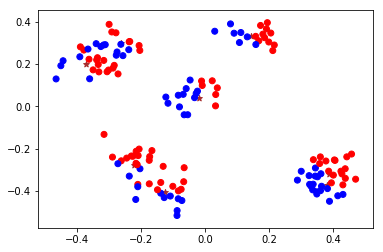

Test


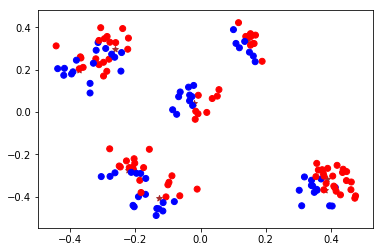

In [19]:
# island of lines
# randomly generate centers, then generate gaussian around that center, 

def build_islands(dim=2, n_island=None, n_per_island=None, scale=0.05):
    if n_island is None:
        n_island = np.random.randint(2,20)
    print(n_island, 'tasks')
    
    Theta = []
    X = []
    Y = []
    centers = np.random.rand(n_island, dim) - 0.5
    for i in range(n_island):
        if n_per_island is None:
            n_per_island = np.random.randint(dim * 5, dim * 20)
        center = centers[i]
        x = np.random.randn(n_per_island, dim) * scale + center
        plt.scatter([center[0]], [center[1]], marker='*', color='brown')
        X.append(x)
        # generate classifier that passes through the center
        theta = np.random.rand(dim)
        b = - theta.dot(center)
        Theta.append([dim, center, scale, n_per_island, theta, b])
        y = (x.dot(theta) + b >= 0) * 2 -1

        Y.append(y)
    return np.vstack(X), np.hstack(Y), Theta

def build_test_islands(Theta, enlarge=1):
    X = []
    Y = []
    test_theta = []
    for dim, center, scale, n_per_island, theta, b in Theta:
        x = np.random.randn(n_per_island * enlarge, dim) * scale + center
        plt.scatter([center[0]], [center[1]], marker='*', color='brown')
        X.append(x)
        y = (x.dot(theta) + b >= 0) * 2 -1
        Y.append(y)
        local_theta = []
        for _ in range(n_per_island * enlarge):
            local_theta.append(list(theta) + [b])
        test_theta.append(np.array(local_theta))
    return np.vstack(X), np.hstack(Y), np.vstack(test_theta)

def recover_subtasks(X, Y, Theta):
    '''Theta comes from build training data'''
    tasks = []
    i = 0
    for _, _, _, n_per_island, _, _ in Theta:
        x = X[i: i+n_per_island]
        y = Y[i: i+n_per_island]
        i = i + n_per_island
        tasks.append((x, y))
    return tasks
    
def plotData(X, y):
    plt.scatter(X[:,0], X[:,1], c=list(map(lambda x: 'b' if x==-1 else 'r', y)))
    plt.show()

ndim = 2
print('Train')
X, Y, Theta = build_islands(ndim)
n_islands = len(Theta)
plotData(X, Y)

print('Test')
Xtest, Ytest, test_theta = build_test_islands(Theta, 1)
plotData(Xtest, Ytest)

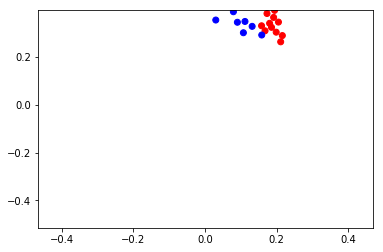

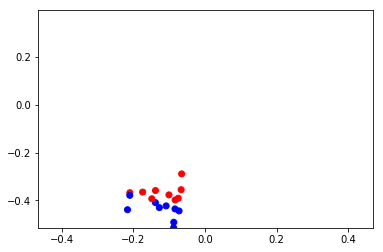

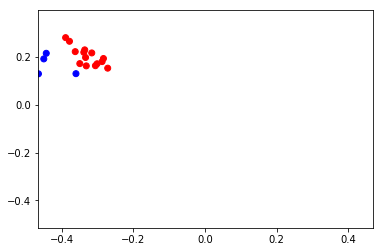

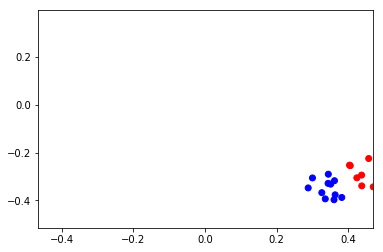

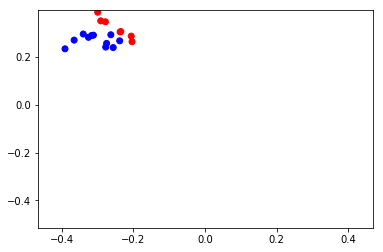

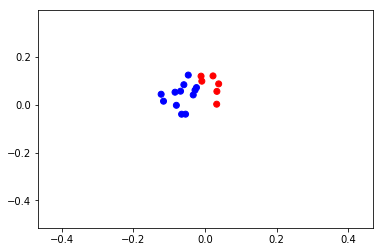

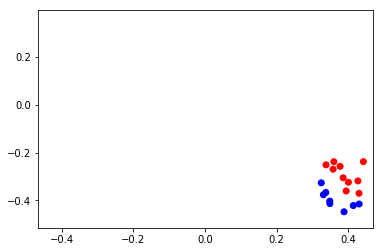

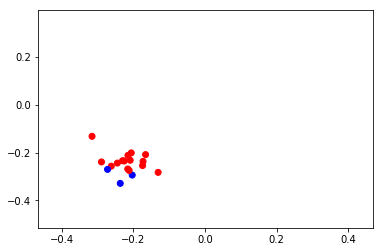

In [20]:
xmin, xmax, ymin, ymax = X[:,0].min(), X[:,0].max(), X[:,1].min(), X[:,1].max()
for x, y in recover_subtasks(X, Y, Theta):
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plotData(x, y)

In [2]:
dataname = #'100d-9-tasks'
#'100d-4tasks'#'100d-6-cluster'# note: please comment this every run so that files are not covered
joblib.dump([X, Y, Theta, Xtest, Ytest, test_theta, ndim, n_islands], 'data/%s.pkl' % dataname)
print(X.shape)

SyntaxError: invalid syntax (<ipython-input-2-104f4bb531c5>, line 1)

In [3]:
dataname = '100d-9-tasks'#'data/100d-4tasks' #'100d-6-cluster' 
X, Y, Theta, Xtest, Ytest, test_theta, ndim, n_islands = joblib.load('data/%s.pkl' % dataname)
print('train shape:', X.shape, 'n_islands:', n_islands, 'ndim:', ndim)

train shape: (84195, 100) n_islands: 9 ndim: 100


baselines

1. a network that has comparable number of parameters that run on this data
2. first cluster, then classify

other things needed to do:
1. try the cosine metric on triangle and square graph and make sure it is near 1
2. try to figure out how to increase gpu memory usage

more ideas:
to force connected partition of input, we need hidden size the same as input size (in this case, undercomplete matrix and overcomplete matrix may merge different regions). But overcomplete matrix gives more power to the network, we want the cluster surface to be smooth, that is the input gradient should be close to zero. We could thus penalyze input gradient, which should give larger regions

1. for switch net, set hidden layer size the same as input size
2. todo: if not work, try to penalyze input gradient for switchnet



In [4]:
print(dataname)
train_data, test_data, ndim, n_islands, test_theta = loadData(dataname)

100d-9-tasks
train shape: (84195, 100) n_islands: 9 ndim: 100
done loading data


In [9]:
D = ndim
K = 20

t = autoencoder_plus_kmeans_plus_weightnet_trainer(dataname, D, K, max_time=0)
t.fit(train_data, n_epochs=15000, valdata=test_data, test_theta=test_theta)

inside <method-wrapper '__repr__' of AutoEncoderTrainer object at 0x7f5ffc25da58>
inside <method-wrapper '__repr__' of KmeansTrainer object at 0x7f5ffc25df60>
Variable containing:
 0.5089  0.4768  0.4537  ...   0.5052  0.5201  0.4921
 0.5142  0.4774  0.4567  ...   0.5126  0.5106  0.4900
 0.5189  0.4710  0.4566  ...   0.5043  0.5052  0.4904
          ...             ⋱             ...          
 0.4385  0.5324  0.4966  ...   0.5103  0.4753  0.4924
 0.4291  0.5326  0.5132  ...   0.5085  0.4744  0.4818
 0.4243  0.5361  0.5088  ...   0.5263  0.4545  0.4910
[torch.cuda.FloatTensor of size 84195x20 (GPU 0)]

inside <method-wrapper '__repr__' of WeightNetTrainer object at 0x7f5ffc25dfd0>
Variable containing:
 0.5120  0.4711  0.4562  ...   0.5066  0.5183  0.4826
 0.4981  0.4798  0.4489  ...   0.4951  0.5474  0.5522
 0.4748  0.4603  0.5149  ...   0.4920  0.5237  0.4983
          ...             ⋱             ...          
 0.4357  0.5240  0.4891  ...   0.5134  0.4797  0.4906
 0.4778  0.4439  0.5